# Process MIMIC using BigQuery

## Libraries and Environment

In [1]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Make pandas dataframes prettier
from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import drive
from google.colab import auth
from google.cloud import bigquery

In [2]:
# authenticate
auth.authenticate_user()
# mount
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set up environment variables
project_id = 'mimic-370210'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# test it works
df = run_query("""
SELECT *
FROM `physionet-data.mimic_core.patients`
WHERE subject_id = 10012853
""")
df

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10012853,F,91,2175,2014 - 2016,NaT


## Check age distribution

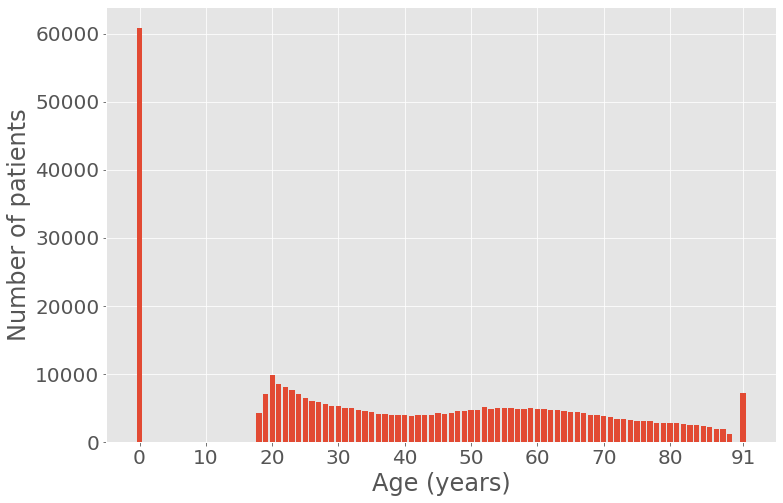

In [4]:
query_age = f"""
SELECT anchor_age, count(*) as n
FROM `physionet-data.mimic_core.patients` pt
group by anchor_age
"""
age = run_query(query_age)
plt.figure(figsize=[12, 8])
plt.bar(age['anchor_age'], age['n'])
plt.xticks([x for x in range(0, 90, 10)] + [91])
plt.ylabel('Number of patients')
plt.xlabel('Age (years)')
plt.show()

In [5]:
age

,anchor_age,n
0,0,60872
1,18,4166
2,19,6965
3,20,9823
4,21,8556
...,...,...
69,86,2159
70,87,1936
71,88,1854
72,89,1153


## Query the Neonates from patients

In [6]:
query_neonates = f"""
SELECT *
FROM `physionet-data.mimic_core.patients`
WHERE anchor_age = 0
"""

neonates = run_query(query_neonates)

In [7]:
neonates.to_csv('/content/drive/MyDrive/MIMIC/Results/neonates.csv')
print(type(neonates))
neonates.head()

<class 'pandas.core.frame.DataFrame'>


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10137012,F,0,2110,2008 - 2010,NaT
1,10158897,M,0,2110,2008 - 2010,NaT
2,10782862,F,0,2110,2008 - 2010,NaT
3,10942655,M,0,2110,2008 - 2010,NaT
4,10999598,M,0,2110,2008 - 2010,NaT


## Query static information
Goal: a table that contains the the foloowing inforamtion for each patient+hadm+stay
[subject_id, hadm_id, stay_id, los, gender, anchor_age, diagnosis]

**This table is already generated and stored in the Google Cloud
Location: project/process_info/static_info**

In [8]:
# query_static_m = f"""
# SELECT *
# FROM  (SELECT
#   static.subject_id,
#   static.hadm_id,
#   static.stay_id,
#   static.los,
#   static.age,
#   static.gender,
#   ddd.diagnoses
#   FROM
#     (SELECT 
#       i.subject_id, 
#       i.hadm_id, 
#       i.stay_id, 
#       i.los,
#       p.anchor_age AS age,
#       p.gender

#     FROM 
#       `physionet-data.mimic_icu.icustays` i
#       INNER JOIN `physionet-data.mimic_core.patients` p ON i.subject_id = p.subject_id) static
#     INNER JOIN
#     (SELECT 
#       subject_id,
#       hadm_id,
#       STRING_AGG(long_title,',' ORDER BY seq_num) AS diagnoses

#     FROM (SELECT 
#         d.subject_id,
#         d.hadm_id,
#         d.seq_num,
#         dd.long_title
#       FROM
#       `physionet-data.mimic_hosp.diagnoses_icd` d
#       INNER JOIN `physionet-data.mimic_hosp.d_icd_diagnoses` dd ON d.icd_code=dd.icd_code AND d.icd_version = dd.icd_version
#       ORDER BY d.subject_id, d.seq_num)
#     GROUP BY
#       subject_id,
#       hadm_id
#     ORDER BY 
#       subject_id) ddd ON static.subject_id = ddd.subject_id AND static.hadm_id = ddd.hadm_id
#   )
# WHERE 
#   diagnoses LIKE '%sepsis%' OR
#   diagnoses LIKE '%Sepsis%' OR
#   diagnoses LIKE '%septic%' OR
#   diagnoses LIKE '%Septic%' 
# """
# static_info_m = run_query(query_static_m)
# static_info_m

In [9]:
query_static_all = f"""
SELECT *
FROM `mimic-370210.process_info.static_info`
"""
static_info_all = run_query(query_static_all)
print('There are {} entries of sepsis patients'.format(static_info_all.shape[0]))
static_info_all

There are 9505 entries of sepsis patients


,sepsis,subject_id,gender,age,los
0,True,16671253,F,18,0.846308
1,True,19853481,F,18,0.811632
2,True,10731984,F,18,2.898310
3,True,13247025,F,18,2.195880
4,True,10474526,F,19,3.383542
...,...,...,...,...,...
9500,True,15395941,M,91,0.750289
9501,True,18216937,M,91,2.331759
9502,True,15952165,M,91,19.940313
9503,True,13821528,M,91,1.865104


## Query event information

**Don't run this to load the whole event info!**

In [10]:
# query_event = f"""
# SELECT *
# FROM `mimic-370210.process_info.event_info`
# """
# event_info_all = run_query(query_event)
# static_info_all

## Help function in the main function

In [11]:
# Filter function: after getting the event table, filter the table to only keep the necessary features
# Input: events as DataFrame, sequence of feature names
# Output: a DataFrame that contains the features from the sequence
def filter_features(df_events, feature_sequence):
    df_filtered = df_events[df_events['abbr'].isin(feature_sequence)]
    df_filtered = df_filtered.reset_index(drop = True)

    return df_filtered

In [12]:
# Function: to perforrm OR operation considering NaN
def f_or(a,b):
    if not np.isnan(a):
        return a
    if not np.isnan(b):
        return b
    return np.nan

In [13]:
# Function: re-arranege the dataset according to the timepoints
# Input: the DataFrames of static_info and event_info
# Outout: the re-arranged DataFrame

# all_columns_original = ['sepsis','subject_id', 'gender', 'age','los',
#                 'NBPs','NBPd','NBPm','Temperature F','HR','RR','Arterial Base Excess',
#                 'FiO2','SpO2','PCO2 (Arterial)','PH (Arterial)','Magnesium',
#                 'Ionized Calcium','Lactic Acid','Sodium (serum)','Potassium (serum)',
#                 'Creatinine (serum)','Chloride (serum)','HCO3 (serum)','Glucose (serum)',
#                 'WBC','BUN','PTT','Platelet Count','time']

def arrange_time(df_static,df_events, all_columns):
    df_final = pd.DataFrame(columns=all_columns)
    # read the static data
    sepsis = df_static.sepsis[0]
    subject_id = df_static.subject_id[0]
    gender = df_static.gender[0]
    age = df_static.age[0]
    los = df_static.los[0]
    # Get the time points from events
    time_sequence = df_events.loc[:,"time"]
    time_sequence.drop_duplicates( keep='first',inplace= True)
    time_sequence = time_sequence.reset_index(drop =True)
    len_time = len(time_sequence)
    for index_time, value in time_sequence.items():
        time = str(value)
        df_current = df_events
        df_current = df_current[df_current['time'].astype(str).str.fullmatch(time)]
        # print('Aviliable DataFrame at this time point',df_current)
        # iterrate each row and set values
        NBPs_final = np.nan
        NBPd_final = np.nan
        NBPm_final = np.nan
        temp_final = np.nan
        hr_final = np.nan
        rr_final = np.nan
        abe_final = np.nan
        FiO2_final = np.nan
        SpO2_final = np.nan
        PCO2_final = np.nan
        ph_final = np.nan
        magnesium_final = np.nan
        calcium_final = np.nan
        latic_final  = np.nan
        sodium_final = np.nan
        potassium_final = np.nan
        creatinine_final = np.nan
        chloride_final = np.nan
        HCO3_final = np.nan
        glucose_final = np.nan
        WBC_final = np.nan
        BUN_final = np.nan
        PTT_final = np.nan
        platelet_final = np.nan
        for index, row in df_current.iterrows():
            if row['abbr'] == 'NBPs':
                NBPs = row['value']
            else: NBPs = np.nan
            NBPs_final = f_or(NBPs_final,NBPs)
            
            if row['abbr'] == 'NBPd':
                NBPd = row['value']
            else: NBPd = np.nan
            NBPd_final = f_or(NBPd_final,NBPd)
            
            if row['abbr'] == 'NBPm':
                NBPm = row['value']
            else: NBPm = np.nan
            NBPm_final = f_or(NBPm_final,NBPm)
            
            if row['abbr'] == 'Temperature F':
                temp = row['value']
            else: temp = np.nan
            temp_final = f_or(temp_final,temp)
            
            if row['abbr'] == 'HR':
                hr = row['value']
            else: hr = np.nan
            hr_final = f_or(hr_final,hr)
            
            if row['abbr'] == 'RR':
                rr = row['value']
            else: rr = np.nan
            rr_final = f_or(rr_final,rr)
            
            if row['abbr'] == 'Arterial Base Excess':
                abe = row['value']
            else: abe = np.nan
            abe_final = f_or(abe_final,abe)
            
            if row['abbr'] == 'FiO2':
                FiO2 = row['value']
            else: FiO2 = np.nan
            FiO2_final = f_or(FiO2_final,FiO2)

            if row['abbr'] == 'SpO2':
                SpO2 = row['value']
            else: SpO2 = np.nan
            SpO2_final = f_or(SpO2_final,SpO2)
            
            if row['abbr'] == 'PCO2 (Arterial)':
                PCO2 = row['value']
            else: PCO2 = np.nan
            PCO2_final = f_or(PCO2_final,PCO2)
            
            if row['abbr'] == 'PH (Arterial)':
                ph = row['value']
            else: ph = np.nan
            ph_final = f_or(ph_final,ph)
            
            if row['abbr'] == 'Magnesium':
                magnesium = row['value']
            else: magnesium = np.nan
            magnesium_final = f_or(magnesium_final,magnesium)
            
            if row['abbr'] == 'Ionized Calcium':
                calcium = row['value']
            else: calcium = np.nan
            calcium_final = f_or(calcium_final,calcium)
            
            if row['abbr'] == 'Lactic Acid':
                latic = row['value']
            else: latic = np.nan
            latic_final = f_or(latic_final,latic)
            
            if row['abbr'] == 'Sodium (serum)':
                sodium = row['value']
            else: sodium = np.nan
            sodium_final = f_or(sodium_final,sodium)
            
            if row['abbr'] == 'Potassium (serum)':
                potassium = row['value']
            else: potassium = np.nan
            potassium_final = f_or(potassium_final,potassium)
            
            if row['abbr'] == 'Creatinine (serum)':
                creatinine = row['value']
            else: creatinine = np.nan
            creatinine_final = f_or(creatinine_final,creatinine)
            
            if row['abbr'] == 'Chloride (serum)':
                chloride = row['value']
            else: chloride = np.nan
            chloride_final = f_or(chloride_final,chloride)
            
            if row['abbr'] == 'HCO3 (serum)':
                HCO3 = row['value']
            else: HCO3 = np.nan
            HCO3_final = f_or(HCO3_final,HCO3)
            
            if row['abbr'] == 'Glucose (serum)':
                glucose = row['value']
            else: glucose = np.nan
            glucose_final = f_or(glucose_final,glucose)
            
            if row['abbr'] == 'WBC':
                WBC = row['value']
            else: WBC = np.nan
            WBC_final = f_or(WBC_final,WBC)
            
            if row['abbr'] == 'BUN':
                BUN = row['value']
            else: BUN = np.nan
            BUN_final = f_or(BUN_final,BUN)
            
            if row['abbr'] == 'PTT':
                PTT = row['value']
            else: PTT = np.nan
            PTT_final = f_or(PTT_final,PTT)
            
            if row['abbr'] == 'Platelet Count':
                platelet = row['value']
            else: platelet = np.nan
            platelet_final = f_or(platelet_final,platelet)

        new_row={'sepsis':sepsis,'subject_id':subject_id, 'gender':gender, 'age':age,'los':los,
                'SBP':NBPs_final,'DBP':NBPd_final,'MAP':NBPm_final,'Temp':temp_final,'HR':hr_final,'Resp':rr_final,'BaseExcess':abe_final,
                'FiO2':FiO2_final,'O2Sat':SpO2_final,'PaCO2':PCO2_final,'pH':ph_final,'Magnesium':magnesium_final,
                'Calcium':calcium_final,'Lactate':latic_final,'Sodium':sodium_final,'Potassium':potassium_final,
                'Creatinine':creatinine_final,'Chloride':chloride_final,'HCO3':HCO3_final,'Glucose':glucose_final,
                'WBC':WBC_final,'BUN':BUN_final,'PTT': PTT_final,'Platelets':platelet_final,'time':time}
        # print('The new row:',new_row)
        # new_row=pd.Series(new_row)
        df_final = df_final.append(new_row, ignore_index=True)

    return df_final
    

## Main function

In [14]:
# Main
feature_sequence = ['NBPs','NBPd','NBPm','Temperature F','HR','RR','Arterial Base Excess',
                    'FiO2','SpO2','PCO2 (Arterial)','PH (Arterial)','Magnesium',
                    'Ionized Calcium','Lactic Acid','Sodium (serum)','Potassium (serum)',
                    'Creatinine (serum)','Chloride (serum)','HCO3 (serum)','Glucose (serum)',
                    'WBC','BUN','PTT','Platelet Count']

all_columns = ['sepsis','subject_id', 'gender', 'age','los',
                'SBP','DBP','MAP','Temp','HR','Resp','BaseExcess',
                'FiO2','O2Sat','PaCO2','pH','Magnesium',
                'Calcium','Lactate','Sodium','Potassium',
                'Creatinine','Chloride','HCO3','Glucose',
                'WBC','BUN','PTT','Platelets','time']   # the features from events are renamed


for index, row in static_info_all.iterrows():
    index += 1
    if index <=6371: continue
    print('-----------Processing the {}th/9505 entry-----------'.format(index))

    current_id = row['subject_id']

    # to generate the static dataset 
    query_static = f"""
      SELECT *
      FROM `mimic-370210.process_info.static_info`
      WHERE subject_id = {current_id}
    """
    static_info = run_query(query_static)

    # to generate the static dataset
    query_event = f"""
    SELECT *
    FROM `mimic-370210.process_info.event_info`
    WHERE subject_id = {current_id}
    """
    event_info = run_query(query_event)
    event_info = filter_features(event_info,feature_sequence)


    # to generate the datasheet in one table
    all_info = arrange_time(static_info,event_info,all_columns)

    if all_info.age[0] == 0:
        all_info.to_csv('/content/drive/MyDrive/MIMIC/Results/neonates/'+str(all_info.subject_id[0])+'.csv', index = False)
    else:
        all_info.to_csv('/content/drive/MyDrive/MIMIC/Results/non_neonates/'+str(all_info.subject_id[0])+'.csv', index = False)

-----------Processing the 6372th/9505 entry-----------
-----------Processing the 6373th/9505 entry-----------
-----------Processing the 6374th/9505 entry-----------
-----------Processing the 6375th/9505 entry-----------
-----------Processing the 6376th/9505 entry-----------
-----------Processing the 6377th/9505 entry-----------
-----------Processing the 6378th/9505 entry-----------
-----------Processing the 6379th/9505 entry-----------
-----------Processing the 6380th/9505 entry-----------
-----------Processing the 6381th/9505 entry-----------
-----------Processing the 6382th/9505 entry-----------
-----------Processing the 6383th/9505 entry-----------
-----------Processing the 6384th/9505 entry-----------
-----------Processing the 6385th/9505 entry-----------
-----------Processing the 6386th/9505 entry-----------
-----------Processing the 6387th/9505 entry-----------
-----------Processing the 6388th/9505 entry-----------
-----------Processing the 6389th/9505 entry-----------
----------